# An Analysis of Political Contributions During the 2020 House of Representatives Election

In this part, you will obtain as much data as you can on the campaign contributions received by each candidate. This data is available through the website https://www.opensecrets.org/. At the end of the project, your group will give a presentation of your findings.

1. Start by scraping the data from the summary page for Tennessee's 2nd District, which is available at https://www.opensecrets.org/races/summary?cycle=2020&id=TN02&spec=N.
    * The data that we want is contained in the "Total Raised and Spent" table.
    * Make a DataFrame showing, for each candidate:
        * the candidate's name
        * the candidate's party
        * state
        * district number
        * whether the candidate was an incumbent
        * whether the candidate won the race
        * the total amount raised by that candidate (as a numeric variable)
        * the total amount spent by the candidate (as a numeric variable)

In [1]:
import sys
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup as BS
import re
from urllib.request import Request, urlopen
import warnings
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
# Question 1

# URL for TN's second district.
Initial_URL = 'https://www.opensecrets.org/races/summary?cycle=2020&id=TN02&spec=N'

# Consider whether to add NaNs for candidates for which Open Secrets does not have data.
def political_df_creation(URL, error_count = 5):
    """Function to create dataframe from first table in open secrets link per state district"""
    
    # Show that I'm human. Open secrets will generate a captcha webpage otherwise.
    request = Request(URL, headers = {'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(request).read().decode('utf-8')
    soup = BS(webpage,'lxml')
    
    # Create dataframe if table exists. Retry if link doesn't work (up to a point).
    district = ''
    try:
        district = pd.read_html(str(soup.find('table', attrs = {'class' : 'DataTable'})))[0]
    except ValueError:
        if error_count > 0:
            error_count -= 1
            political_df_creation(URL, error_count = error_count)
        else:
            print(f"{URL} is not working.")
            sys.exit(1) 
    
    def district_df_clean_up(district):
        """Function to clean up district dataframe."""
        
        # Pull out name, account for hyphenation.
        district['Name'] = (
            district['Candidate'].\
            str.extract(r'([A-Za-z]+\s*-*[A-Za-z\.]*\s*-*[A-Za-z]+)', expand = True)
        )
        
        # Pull out party.
        district['Party'] = (
            district['Candidate'].\
            str.extract(r'(\([A-Z1-9]\))', expand = True)
        )
        
        # Pull out incumbent value, and set to boolean values.
        incumbent = re.compile(r'\s(Incumbent)')
        district['Incumbent'] = ''
        for i in district['Candidate']:
            if incumbent.search(i):
                district['Incumbent'].loc[district['Candidate'] == i] = True
            else:
                district['Incumbent'].loc[district['Candidate'] == i] = False
                
        # Pull out winner, set to boolean values.
        winner = re.compile(r'\s(Winner)')
        district['Winner'] = ''
        for i in district['Candidate']:
            if winner.search(i):
                district['Winner'].loc[district['Candidate'] == i] = True
            else:
                district['Winner'].loc[district['Candidate'] == i] = False
        
        # Drop mashed up column and a couple others.
        district = (
            district.drop(columns = ['Candidate', 'Cash on Hand', 'Last Report'])
        )
        
        # Set raised and spent columns to numbers.
        district['Raised'] = (
            district['Raised'].\
            str.replace(',', '', regex = False).\
            str.replace('$', '', regex = False).astype('int64')
        )
        district['Spent'] = (
            district['Spent'].\
            str.replace(',', '', regex = False).\
            str.replace('$', '', regex = False).astype('int64')
        )
        
        # Pull out state and district number from homelink.
        homelink = str(soup.find('link', href=True))
        state = re.compile(r'id=([A-Z]+)\d*')
        state = state.search(homelink)
        district['State'] = state.group(1)

        district_number = re.compile(r'id=[A-Z]+(\d*)')
        district_number = district_number.search(homelink)
        district['District'] = district_number.group(1)
        
        # Rearrange columns for readability.
        cols = district.columns.tolist()
        cols = cols[2:len(cols)+1] + cols [0:2]
        district = district[cols]
        return district
    
    district = district_df_clean_up(district)
    return district


political_df_creation(Initial_URL)

,Name,Party,Incumbent,Winner,State,District,Raised,Spent
0,Tim Burchett,(R),True,True,TN,02,1336276,878488
1,Renee Hoyos,(D),False,False,TN,02,812784,816793


2. Once you have working code for Tennessee's 2nd District, expand on your code to capture all of Tennessee's districts.

In [3]:
# Question 2
# Cycle through each of the nine TN districts using above functions.
for i in range(1,10):
    district = (
        political_df_creation(f'https://www.opensecrets.org/races/summary?cycle=2020&id=TN0{i}&spec=N')
    )
    if i == 1:
        all_districts = district
    else:
        all_districts = all_districts.merge(district, how = 'outer')
all_districts

,Name,Party,Incumbent,Winner,State,District,Raised,Spent
0,Diana Harshbarger,(R),False,True,TN,01,2126946,1869100
1,Blair Nicole Walsingham,(D),False,False,TN,01,140209,134995
2,Tim Burchett,(R),True,True,TN,02,1336276,878488
3,Renee Hoyos,(D),False,False,TN,02,812784,816793
4,Chuck Fleischmann,(R),True,True,TN,03,1051653,381411
5,Meg Gorman,(D),False,False,TN,03,85843,77760
6,Scott Desjarlais,(R),True,True,TN,04,331464,392499
7,Christopher Hale,(D),False,False,TN,04,308731,302996
8,Jim Cooper,(D),True,True,TN,05,936569,1332131
9,John Rose,(R),True,True,TN,06,1050429,625688


3. Once you have working code for all of Tennessee's districts, expand on it to capture all states and districts. The number of representatives each state has can be found in a table on this page: https://www.britannica.com/topic/United-States-House-of-Representatives-Seats-by-State-1787120

In [4]:
# Question 3
# Cull abbreviation list from boy scouts website for purposes of full scrape.
abbreviations_url = 'https://www.scouting.org/resources/los/states/'
request = Request(abbreviations_url, headers = {'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(request).read().decode('utf-8')
soup = BS(webpage,'lxml')
abbreviations = pd.read_html(str(soup.find('div', attrs = {'class' : 'table-responsive'})))[0]
# Some territories included.
abbreviations = abbreviations.loc[~abbreviations['Postal'].isin(['GU', 'PR', 'VI', 'CZ'])].drop(columns = 'Standard')

In [5]:
# Cull number of representatives list for purposes of final scrape.
number_of_reps_url = 'https://www.britannica.com/topic/United-States-House-of-Representatives-Seats-by-State-1787120'
response = requests.get(number_of_reps_url)
soup = BS(response.text)
number_of_reps = (
    pd.read_html(str(soup.find('table')))[0].\
    rename(columns = {'state':'State', 
                      'representatives':'Representatives'})
)

# Merge the two dataframes together.
reps_plus_abbreviations = pd.merge(abbreviations, number_of_reps, how = 'outer')
reps_plus_abbreviations['Representatives'].loc[reps_plus_abbreviations['Postal'] == 'DC'] = 1
reps_plus_abbreviations = reps_plus_abbreviations[:51].astype({'Representatives':'int64'})
reps_plus_abbreviations.to_csv("Write_Data_Here/reps_plus_abbreviations.csv", index = False)

In [6]:
# Set enumeration value.
e = 0
# Cycle through all links for each district.
for row in reps_plus_abbreviations.itertuples():
    abbrev = row[2]
    reps_endpoint = row[3] + 1
    # DC is different.
    if abbrev != 'DC':
        for k in range(1, reps_endpoint):
            if k < 10:
                url = f'https://www.opensecrets.org/races/summary?cycle=2020&id={abbrev}0{k}&spec=N'
                district = political_df_creation(url)
            else:
                url = f'https://www.opensecrets.org/races/summary?cycle=2020&id={abbrev}{k}&spec=N'
                district = political_df_creation(url)
            # Set the first district as the base into which all others will merge.
            if e == 0:
                all_districts = district
                e += 1
            # Merge everyone else.
            else:
                all_districts = all_districts.merge(district, how = 'outer')
    else:
        url = f'https://www.opensecrets.org/races/summary?cycle=2020&id=DC00'
        district = political_df_creation(url)
        all_districts = all_districts.merge(district, how = 'outer')
    # Delay, otherwise will get HTTPS 429 from server.
    time.sleep(0.05)

In [7]:
# Add FIPS codes to all_districts.
number_of_reps_url = 'https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696'
response = requests.get(number_of_reps_url)
soup = BS(response.text)
FIPS = pd.read_html(str(soup.find('div', attrs = {'id' : 'detail'})))[0]
dict_FIPS = dict(xy for xy in zip(FIPS['Postal Code'],FIPS['FIPS']))
all_districts['FIPS'] = ''
for i in all_districts['State']:
    for key in dict_FIPS.keys():
        if key == i:
            all_districts['FIPS'].loc[all_districts['State'] == i] = dict_FIPS[key]
all_districts['FIPS'].loc[all_districts['State'] == 'DC'] = 11

In [8]:
# Write dataframe to csv file.
all_districts.to_csv("Write_Data_Here/all_districts.csv", index = False)

4. Using your scraped data, investigates different relationships between candidates and the amount of money they raised. Here are some suggestions to get you started, but feel free to pose you own questions or do additional exploration:  

In [9]:
# Question 4
# Read in dataframe and pull info.
all_districts = pd.read_csv("Write_Data_Here/all_districts.csv")
all_districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       897 non-null    object
 1   Party      897 non-null    object
 2   Incumbent  897 non-null    bool  
 3   Winner     897 non-null    bool  
 4   State      897 non-null    object
 5   District   897 non-null    int64 
 6   Raised     897 non-null    int64 
 7   Spent      897 non-null    int64 
 8   FIPS       897 non-null    int64 
dtypes: bool(2), int64(4), object(3)
memory usage: 50.9+ KB


a. How often does the candidate who raised more money win a race?  

b. How often does the candidate who spent more money win a race? 

In [10]:
# Questions 4(a) and (b)
# Create a groupby dataframe culling the max amounts raised.
relevant_columns = ['Raised', 'Spent']

for i in relevant_columns:
    rtm_amounts = (
        pd.DataFrame(all_districts.groupby(['State', 'District'])['Raised'].max()).\
        reset_index().assign(Most = True)
    )
    # Merge with all_districts.
    all_districts = (
        all_districts.merge(rtm_amounts, how = 'outer')
    )
    # Fill in NA values with false since not max values.
    all_districts['Most'].loc[all_districts['Most'].isna()] = False
    # Run a crosstab and calculate precentage.
    percentage = pd.crosstab(all_districts['Winner'], all_districts['Most'])[1][1]/\
    pd.crosstab(all_districts['Winner'], all_districts['Most'])[1].sum()
    print(f"The candidate that {i.lower()} the most money won ~{'{:.0%}'.format(round(percentage,2))} of the time.")

The candidate that raised the most money won ~88% of the time.
The candidate that spent the most money won ~88% of the time.


c. Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race? 

**Money raised seems to strongly correlate with whether a candidate will win a particular race, but money raised may be a product of notoriety or connections, which may be the real causal factor for winning.**

d. How often does the incumbent candidate win a race?

In [11]:
# Question 4(d)
# Generate percentage of incumbents who were winners.
percentage = pd.crosstab(all_districts['Winner'], all_districts['Incumbent'])[1][1]/\
pd.crosstab(all_districts['Winner'], all_districts['Incumbent'])[1].sum()
print(f"~{'{:.0%}'.format(round(percentage,2))} of the time.")

~96% of the time.


e. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


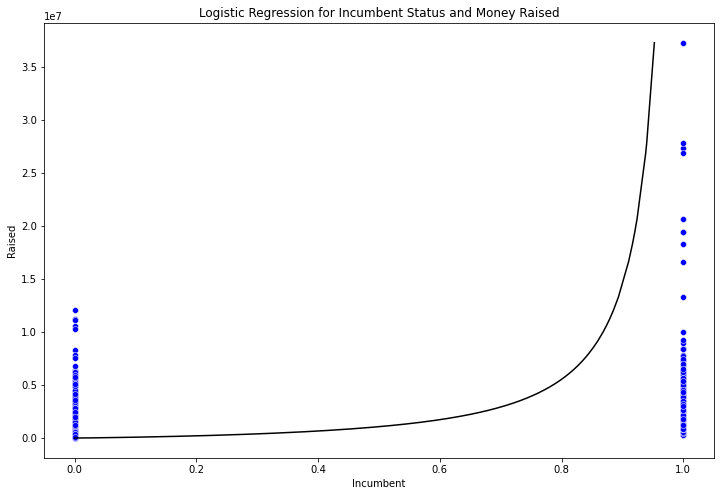

In [12]:
# Question 4(e)
# Run a logistic regression on incumbency vs. money raised, but plot inversely.
all_districts['Incumbent'] = pd.get_dummies(all_districts['Incumbent'], drop_first = True)
all_districts = all_districts.loc[all_districts['Raised'] > 0]

x_values = sm.add_constant(np.log(all_districts['Raised']))
incumbent_model = sm.Logit(endog = all_districts['Incumbent'], exog = x_values).fit()
all_districts['Predicted Values'] = incumbent_model.predict(x_values)

fig, ax = plt.subplots(figsize = (12, 8))
sns.scatterplot('Incumbent', 'Raised', data = all_districts, color = 'blue', ax = ax);
sns.lineplot('Predicted Values', 'Raised', data = all_districts, color = 'black', ax = ax);
plt.xlim(-0.05,1.05)
plt.title('Logistic Regression for Incumbent Status and Money Raised');

**Incumbents are generally able to raise more money, so any consideration of whether raising more money makes a candidate more likely to win needs to account for incumbency as a potential confounding factor.**